In [1]:
import numpy as np
# import dpctl
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from munch import DefaultMunch, Munch
params = DefaultMunch()
params.dataset_name = 'AliExpress_NL'
params.dataset_path = './data/'

In [3]:
from datasets import get_dataset
import os
from torch.utils.data import DataLoader
train_dataset = get_dataset(params.dataset_name, os.path.join(
        params.dataset_path, params.dataset_name) + '/train.csv')
test_dataset = get_dataset(params.dataset_name, os.path.join(
    params.dataset_path, params.dataset_name) + '/test.csv')


In [4]:
import joblib
memory = joblib.Memory('./joblib_tmp', verbose=1)
@memory.cache
def get_numerical():
    # X_train = np.hstack((train_dataset.categorical_data, train_dataset.numerical_data))
    X_train = train_dataset.numerical_data
    # X_train = train_dataset.categorical_data
    y_train = np.sum(train_dataset.labels, axis=1)
    # X_test = np.hstack((test_dataset.categorical_data, test_dataset.numerical_data))
    X_test = test_dataset.numerical_data
    # X_test = test_dataset.categorical_data
    y_test = np.sum(test_dataset.labels, axis=1)
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = get_numerical()

In [6]:
np.corrcoef( train_dataset.labels[:, 0], train_dataset.labels[:, 1] )

array([[1.        , 0.18878797],
       [0.18878797, 1.        ]])

In [45]:
# from pathlib import Path
# import torch
# from models.layers import EmbeddingLayer
# from models import get_model
# from utils.general import LOGGER, colorstr, yaml_load, check_git_info, init_seeds
# params.model_name = 'mmoe'
# params.embed_dim = 128
# params.weights = "runs/NL_basic/exp_22/mmoe_12.pt"
# params.expert_num = 8

# @memory.cache
# def get_embeded(limit = 10):
#     field_dims = train_dataset.field_dims
#     numerical_num = train_dataset.numerical_num
#     embed_dim = params.embed_dim
#     task_num = train_dataset.labels_num
#     model = get_model(params.model_name, field_dims, numerical_num, task_num,
#                       params.expert_num, params.embed_dim)
#     weights = Path(params.weights or '').resolve()
#     if weights.is_file() and weights.exists():
#         state_dict = torch.load(weights)
#         model.load_state_dict(state_dict)
#         LOGGER.info(f"{colorstr('模型')}: 迁移参数完成。")
#     embedding = model.embedding
#     # 获取数据
#     train_cat = np.vstack((embedding(torch.LongTensor(train_dataset.categorical_data[:limit//2])), 
#                            embedding(torch.LongTensor(train_dataset.categorical_data[limit//2:]))))
#     test_cat = np.vstack((embedding(torch.LongTensor(test_dataset.categorical_data[:limit//2])),
#                             embedding(torch.LongTensor(test_dataset.categorical_data[limit//2:]))))
    
#     X_train = np.hstack((train_cat, train_dataset.numerical_data[:limit]))
#     y_train = np.sum(train_dataset.labels[:limit], axis=1)
#     X_test = np.hstack((test_cat, test_dataset.numerical_data[:limit]))
#     y_test = np.sum(test_dataset.labels[:limit], axis=1)
#     return X_train, y_train, X_test, y_test
# em_X_train, em_y_train, em_X_test, em_y_test = get_embeded()

In [46]:
len(train_dataset)

12157894

In [47]:
PCA_X = np.vstack((X_train, X_test))

In [48]:
PCA_y = np.hstack((y_train, y_test))

In [49]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(PCA_X)
print(pca.explained_variance_ratio_)

[0.1772083  0.11063951 0.08908603]


In [50]:
trans_X = pca.transform(PCA_X)
trans_X.shape

(17717195, 3)

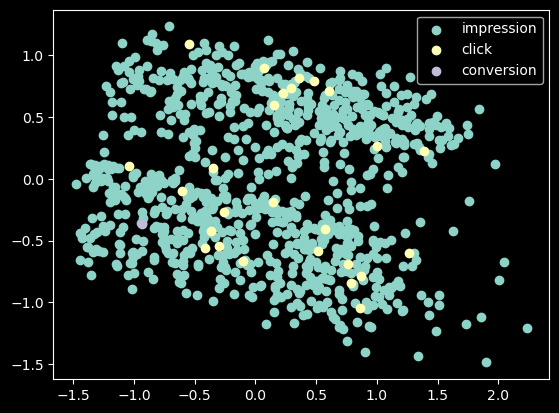

In [54]:
from matplotlib import pyplot as plt
indexes = np.random.randint(0, len(trans_X), 1000)
def draw2d(X, y, label_names):
    for i, name in enumerate(label_names):
        plt.scatter(X[y[:]==i, 0], X[y[:]==i, 1], label=name)
    plt.legend()
    plt.savefig('fig/PCA2d.png')
# plt.show()
draw2d(trans_X[indexes], PCA_y[indexes], ['impression', 'click', 'conversion'])

In [55]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

# plt.rcParams['font.sans-serif'] = ['SimHei']
def draw(X, y, label_names, elev=60, azim=30):
    # X = np.array(X)
    # y = np.array(y)
    fig = plt.figure(1, figsize=(12, 3))
    ax = fig.add_subplot(111, projection="3d", elev=elev, azim=azim) 
    ax.set_position([0, 0, 0.95, 1])

    # for label, name in enumerate(label_names[4:7]):
    for label, name in enumerate(label_names):
        ax.text3D(
            X[y == label, 0].mean(),
            X[y == label, 1].mean(),
            X[y == label, 2].mean() + 2,
            name,
            horizontalalignment="center",
            bbox=dict(alpha=0.3, edgecolor="b", facecolor="r"),
        )
    # Reorder the labels to have colors matching the cluster results
    # y = np.choose(y, [1, 2, 0]).astype(float)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y,
               edgecolor='k')

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

    ax.set_xlabel("Component 0")
    ax.set_ylabel("Component 1")
    ax.set_zlabel("Component 2")
    # ax.set_title("Ground Truth")
    # ax.dist = 12
    # ax.dist = 24
    ax.dist = 6

    plt.savefig('fig/PCA3d.png')
    # plt.show()

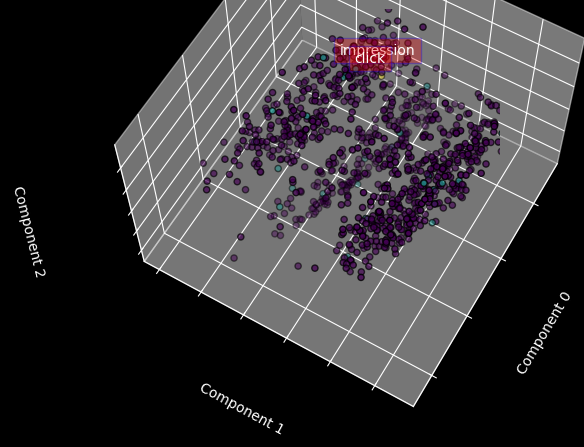

In [56]:
draw(trans_X[indexes], PCA_y[indexes], ['impression', 'click', 'conversion'])

In [59]:
train_indexes = np.hstack((indexes, np.random.randint(0, len(trans_X), 1000*10)))
train_indexes.shape

(11000,)

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2) # 只能是3-1维
trans_X_lda = lda.fit_transform(PCA_X[train_indexes], PCA_y[train_indexes])
trans_X_lda.shape

(11000, 2)

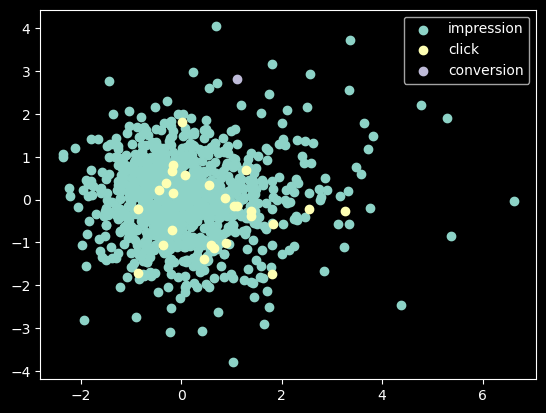

In [63]:
draw2d(trans_X_lda[:len(indexes), :], PCA_y[indexes], ['impression', 'click', 'conversion'])

In [ ]:
# # 完全版 lda
# trans_X_lda = lda.fit_transform(PCA_X, PCA_y)
# draw2d(trans_X_lda[indexes], PCA_y[indexes], ['impression', 'click', 'conversion'])

In [64]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=3) 
trans_X_tsne = tsne.fit_transform(PCA_X[train_indexes], PCA_y[train_indexes])
trans_X_tsne.shape

/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:137: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:153: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


(11000, 3)

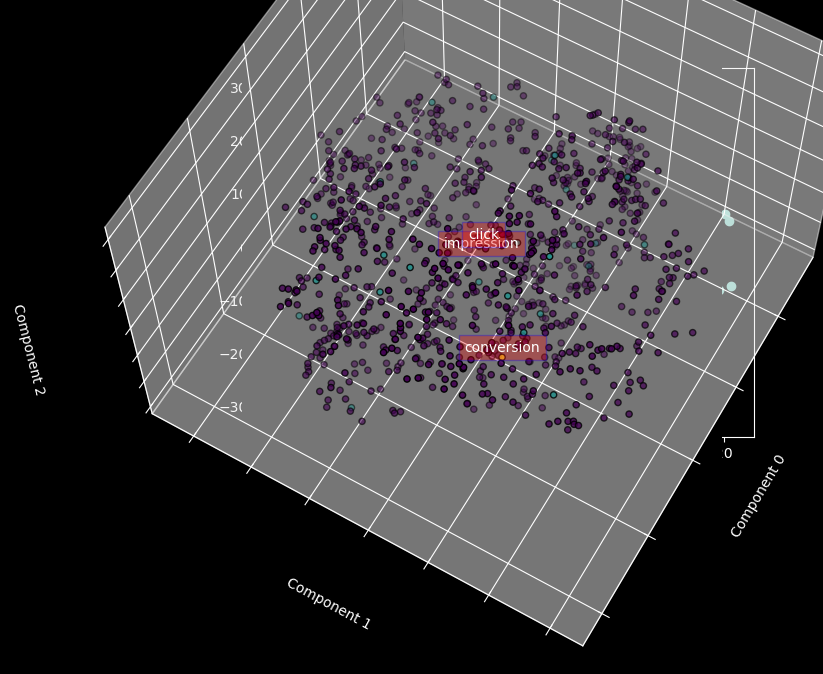

In [66]:
draw2d(trans_X_tsne[:len(indexes), :], PCA_y[indexes],['impression', 'click', 'conversion'])
draw(trans_X_tsne[:len(indexes), :], PCA_y[indexes],['impression', 'click', 'conversion'])